In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np

# OSM & GTFS Generation

Here you can build a simple **road network** and **transit route** for a fake city. We use these outputs for testing network combination tooling.

**Outputs:**
- **OSM Road Network**
- **GTFS Bus Transit**

These outputs are based on a sequential generation of the following city features:

**Facilities:** Generate activity locations (including households) clustered around centres of density.

**Road Networks:** Generate a road network based on facility density.

**Road Transit Routes:** Generate road transit routes using the road network.

We additionally apply spatial some jitter to add noise.

In [2]:
from citychef import spatial
from citychef import graph
from citychef import household as hh
from citychef import tree
from citychef import osm
from citychef import gtfs

In [3]:
# uncomment if you are making changes to core modules
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

In [4]:
city_dir = "./osm_gtfs_example"

In [5]:
if not os.path.exists(city_dir):
    os.mkdir(city_dir)
else:
    print("WARNING - potentially overwritting previous results")

WARNING - potentially overwritting previous results


### Facilities
First we generate the location of various facilities, including households where the populations will live and activity locations such work places, leisure, education, shopping and health facilities.

#### Method
1. define seed bounding box (DEGREES) - TODO add reprojection
2. uniformly sample 'centres' within bounding box
3. poisson sample number of facilities of each type around each centre
4. gaussian sample locations of facilities around each centre

In [6]:
bbox = np.array([[0,0],[.01,.01]])  # min x, min y, max x, max y (DEGREES)
centres = spatial.Centres(bbox, number=1)
facilities = {
    'households': spatial.Clusters(centres, size=1000, sigma=.005),
}
bbox = spatial.collect_bbox(facilities) # adjust the bbox for max extends

### Road Network

We build a road network for car travel. We use a quad tree to define the density of the network so that accessibility is likely better where household density is higher. The connectivity of the resulting networks is based on parent - child relationships within the quad tree. This results in poor connectivity between neighbouring quad grids if they are removed by several generations, ie their shared parent is distant.

Edges are assigned a distance, a freespeed (based on distance) and a freeflow traversal time.

#### Method

1. Build a grid tree with maximum household density of N.
2. Build a network of roads from the grid tree

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-0.009830156416397264,
 0.025384248319187515,
 -0.00906196331326127,
 0.022271905584673582)

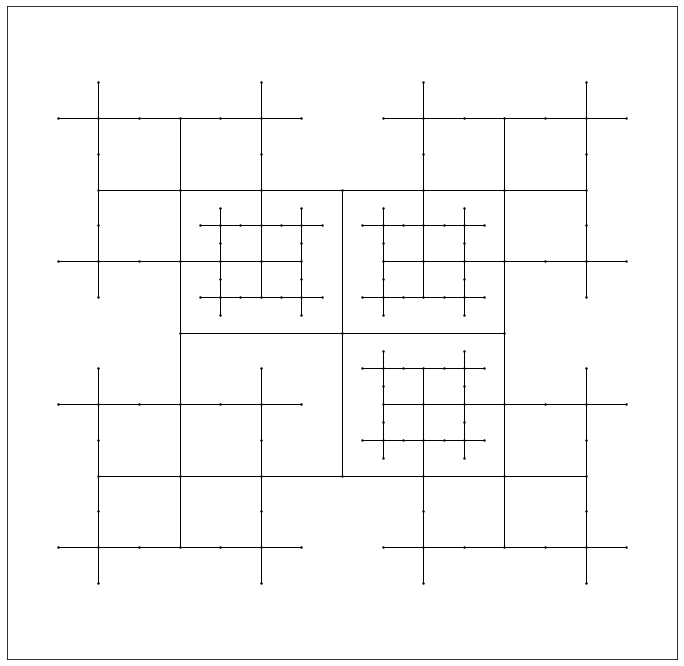

In [17]:
car_network = graph.TreeNetwork(
    bbox, facilities['households'], grid='regular', max_points=200
)
car_network.plot()
plt.axis('equal')

### Bus Network

We build a bus network for public transit travel on the road network. A route generation algorithm attempts to build viable routes by making weighted random walks across the road network from seed locations.

The random walks are seeded based on a weighted sample from the road network vertices. Where the vertices are weighted by household density at each vertices. From each seed location the weighted random walk traverses the possible network based on weighted random choice of each possible step. Where weights are based on the household density of the possible choices, the straightness of the resulting graph and the number of times the edges have already been traversed by a route. Routes cannot repeat the previous edge so that the traversal ends at dead ends in the road network or when a maximum number of stops is reached.

Edges are assigned a distance, a freespeed (based on distance) and a freeflow traversal time as per the underlying road network. For simplicity, no consideration is made of a schedule or interchange times.

#### Method

1. Build an array of houshold density for each vertices of the road network graph
2. Sample number of required routes based on population and a poisson distribution
3. Generate route
4. Add generated routes that meet minimum requirements for stops and length
5. Combine routes to form total bus network graph

In [8]:
buses = graph.Transit(car_network, facilities['households'], density_radius=.0001)
buses.build_routes(num_routes=1, max_length=11, min_length=11, straightness=2)

### Apply Noise to the Transit Network

To add noise to our test data we:

i) add interpolate some new transit stops so that the stop locations do not have corresponding road network nodes.

ii) add some spatial jitter to transit stop locations.

In [9]:
buses.interpolate_routes()

In [10]:
buses.jitter_locations(30/111139)

(-0.00924934887510005,
 0.024803440777890304,
 -0.008465770141731032,
 0.021675712413143346)

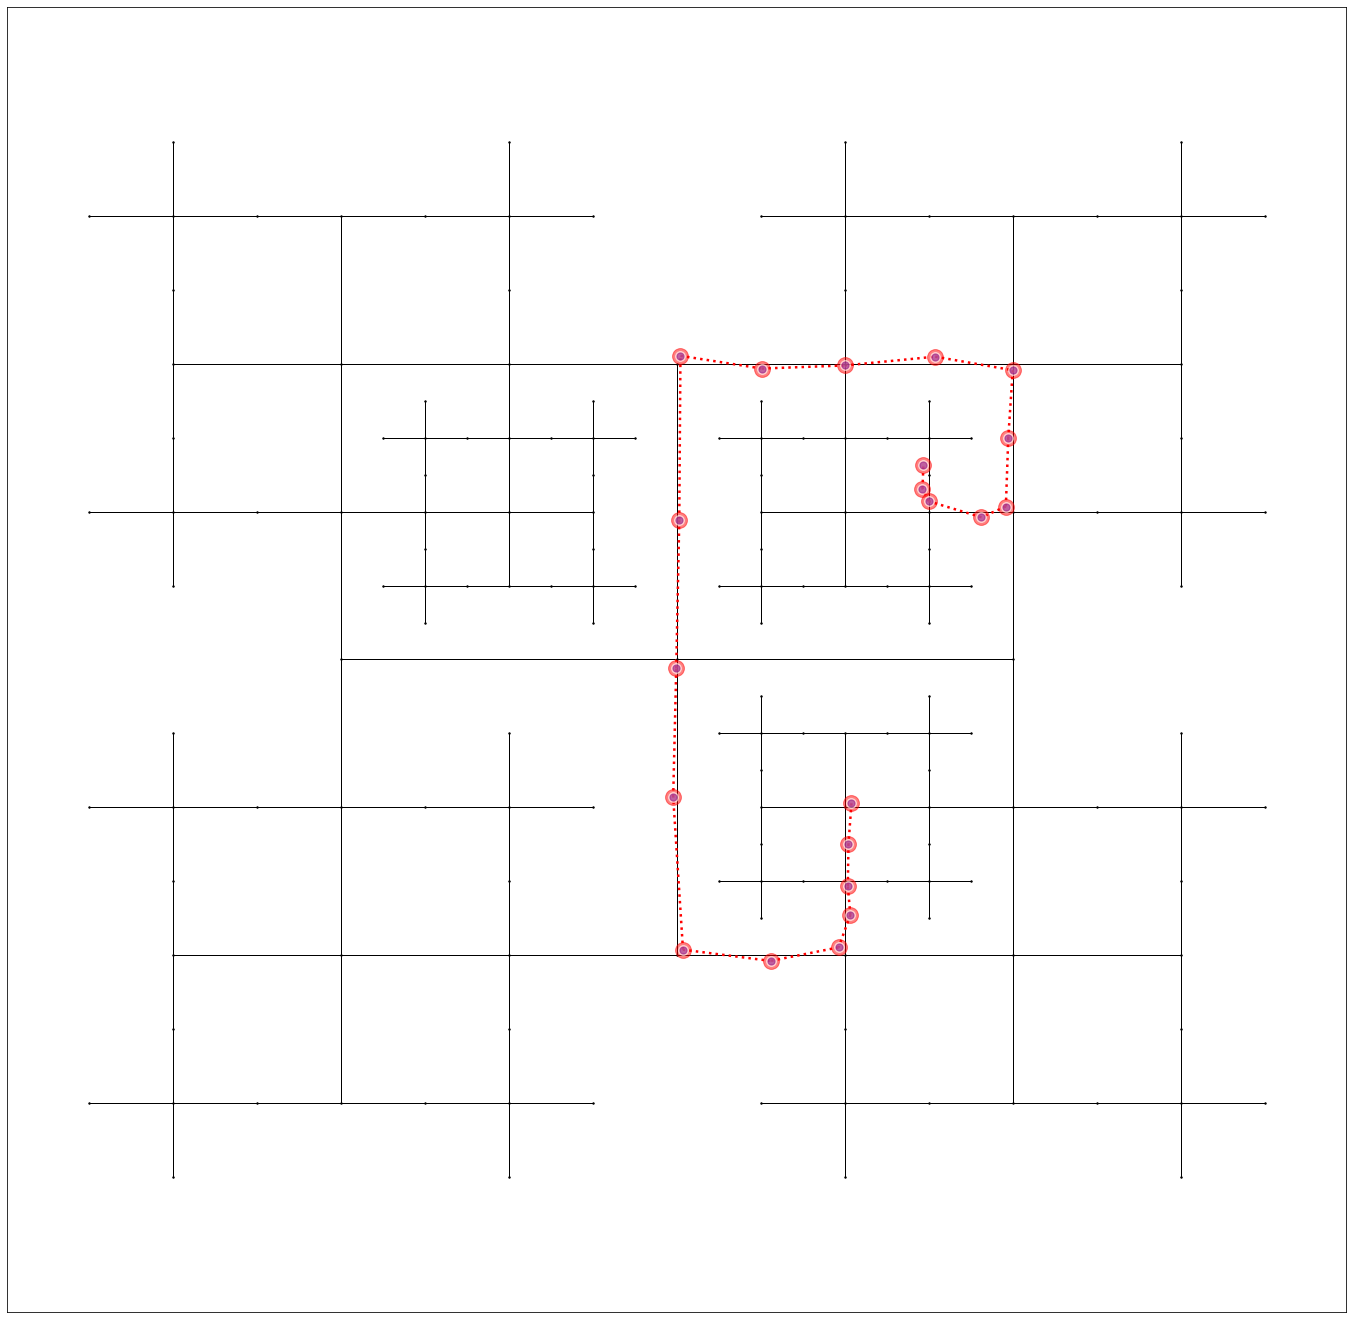

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
car_network.plot(ax=ax)
buses.plot(ax=ax)
plt.axis('equal')

In [12]:
# fig.savefig('image.png')

In [13]:
# check min and max distances
print(buses.min_link_length * 111139)
print(buses.max_link_length * 111139) # approx conv to m

104.46018194431129
655.2103544382347


### Outputs

Convert the road network to OSM format xml and the transit to GTFS.

In [15]:
osm.nx_to_osm(
    g=car_network.g,
    path=os.path.join(city_dir, "osm.xml")
)

Output()

Output()

In [16]:
gtfs.build_gtfs(
    transit=buses,
    out_dir=city_dir,
    agency_id=0,
    agency_name='test_bus_inc'
)

Output()